## CS675 intro to datascience

### project 2

###Rishiraj Rana


According to the brief, i have used following four algorithms on the dataset to derive predictions for customers churning:
1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

also these four models in three stages of analysis:
1. normal techniques for predictions
2. using SMOTE techniques for addressing data imbalance in predictions
3. normally, but using hyperparameter tuning to optimize the model for predictions (only Random Forest and XGBoost)

i wibb be comparing the following metrics for each model and analysis stage:
1. Accuracy
2. Precision
3. Recall
4. F1 Score


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import statsmodels
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('/content/telco-customer-churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
for col in df.columns:
  print(col,df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [5]:
#label encoding

for col in df.columns:
    # i have only used 0 and 1 for binary values
    df.loc[df[col] == "Yes", col] = 1
    df.loc[df[col] == "No", col] = 0
    df.loc[df[col] == "Female", col] = 0
    df.loc[df[col] == "Male", col] = 1
    # everything else is represented with a distinct integer
    df.loc[df[col] == "No phone service", col] = 2
    df.loc[df[col] == "No internet service", col] = 3
    df.loc[df[col] == "DSL", col] = 4
    df.loc[df[col] == "Fiber optic", col] = 5
    df.loc[df[col] == "Month-to-month", col] = 6
    df.loc[df[col] == "One year", col] = 7
    df.loc[df[col] == "Two year", col] = 8
    df.loc[df[col] == "Electronic check", col] = 9
    df.loc[df[col] == "Mailed check", col] = 10
    df.loc[df[col] == "Bank transfer (automatic)", col] = 11
    df.loc[df[col] == "Credit card (automatic)", col] = 12
    # setting missing values to -1, so that these values correspond to missing values
    df.loc[df[col] == " ", col] = -1

In [6]:
# obtaining list of all columns which we need to convert
cols_to_convert_to_int = df.columns[np.where(df.dtypes=="object")]
cols_to_convert_to_int = cols_to_convert_to_int[1:] # we are excluding the customerID column

In [7]:
# converting each of the targeted columns to integer type
for col in cols_to_convert_to_int:
    df[col] = pd.to_numeric(df[col])

In [8]:
df.dtypes

,0
customerID,object
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,int64


In [9]:
df = df.drop([0])

In [10]:
#splitting the dataset into 80-20 ratio (training-testing splits)

X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

column_names = ["method","accuracy","precision","recall","f1"]
final_results_no_smote = pd.DataFrame(columns=column_names)
final_results_smote = pd.DataFrame(columns=column_names)
final_results_hyp = pd.DataFrame(columns=column_names)

normal predictions

In [11]:
# 1. NAIVE BAYES

nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_predictions = nb.predict(X_test)

In [12]:
nb_accuracy_score = accuracy_score(Y_test,nb_predictions)
nb_precision_score = precision_score(Y_test,nb_predictions)
nb_recall_score = recall_score(Y_test,nb_predictions)
nb_f1_score = f1_score(Y_test,nb_predictions)
nb_confusion = confusion_matrix(Y_test,nb_predictions)

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Naive Bayes",nb_accuracy_score,nb_precision_score,nb_recall_score,nb_f1_score]

In [15]:
model_dt = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt.fit(X_train, Y_train)
dt_predictions = model_dt.predict(X_test)

In [16]:
dt_accuracy_score = accuracy_score(Y_test,dt_predictions)
dt_precision_score = precision_score(Y_test,dt_predictions)
dt_recall_score = recall_score(Y_test,dt_predictions)
dt_f1_score = f1_score(Y_test,dt_predictions)
dt_confusion = confusion_matrix(Y_test,dt_predictions)

In [17]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Descion Trees",dt_accuracy_score,dt_precision_score,dt_recall_score,dt_f1_score]

In [18]:
#2. LOGISTIC REGRESSION

lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
lr_accuracy_score = accuracy_score(Y_test,lr_predictions)
lr_precision_score = precision_score(Y_test,lr_predictions)
lr_recall_score = recall_score(Y_test,lr_predictions)
lr_f1_score = f1_score(Y_test,lr_predictions)
lr_confusion = confusion_matrix(Y_test,lr_predictions)

In [20]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Logistic Regression",lr_accuracy_score,lr_precision_score,lr_recall_score,lr_f1_score]

In [21]:
#3. RANDOM FOREST

rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)
rf_predictions = [int(x) for x in np.round(rf_predictions,0)]

In [22]:
rf_accuracy_score = accuracy_score(Y_test,rf_predictions)
rf_precision_score = precision_score(Y_test,rf_predictions)
rf_recall_score = recall_score(Y_test,rf_predictions)
rf_f1_score = f1_score(Y_test,rf_predictions)
rf_confusion = confusion_matrix(Y_test,rf_predictions)

In [23]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Random Forest",rf_accuracy_score,rf_precision_score,rf_recall_score,rf_f1_score]

In [24]:
#4. XGBOOST

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,Y_train)
xgb_predictions = xgb_classifier.predict(X_test)

In [25]:
xgb_accuracy_score = accuracy_score(Y_test,xgb_predictions)
xgb_precision_score = precision_score(Y_test,xgb_predictions)
xgb_recall_score = recall_score(Y_test,xgb_predictions)
xgb_f1_score = f1_score(Y_test,xgb_predictions)
xgb_confusion = confusion_matrix(Y_test,xgb_predictions)

In [26]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["XGBoost",xgb_accuracy_score,xgb_precision_score,xgb_recall_score,xgb_f1_score]

In [27]:
#comparing results for no smote

final_results_no_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762
1,Descion Trees,0.797019,0.630000,0.519231,0.569277
2,Logistic Regression,0.810504,0.652038,0.571429,0.609078
3,Random Forest,0.789922,0.604938,0.538462,0.569767
4,XGBoost,0.793471,0.608309,0.563187,0.584879


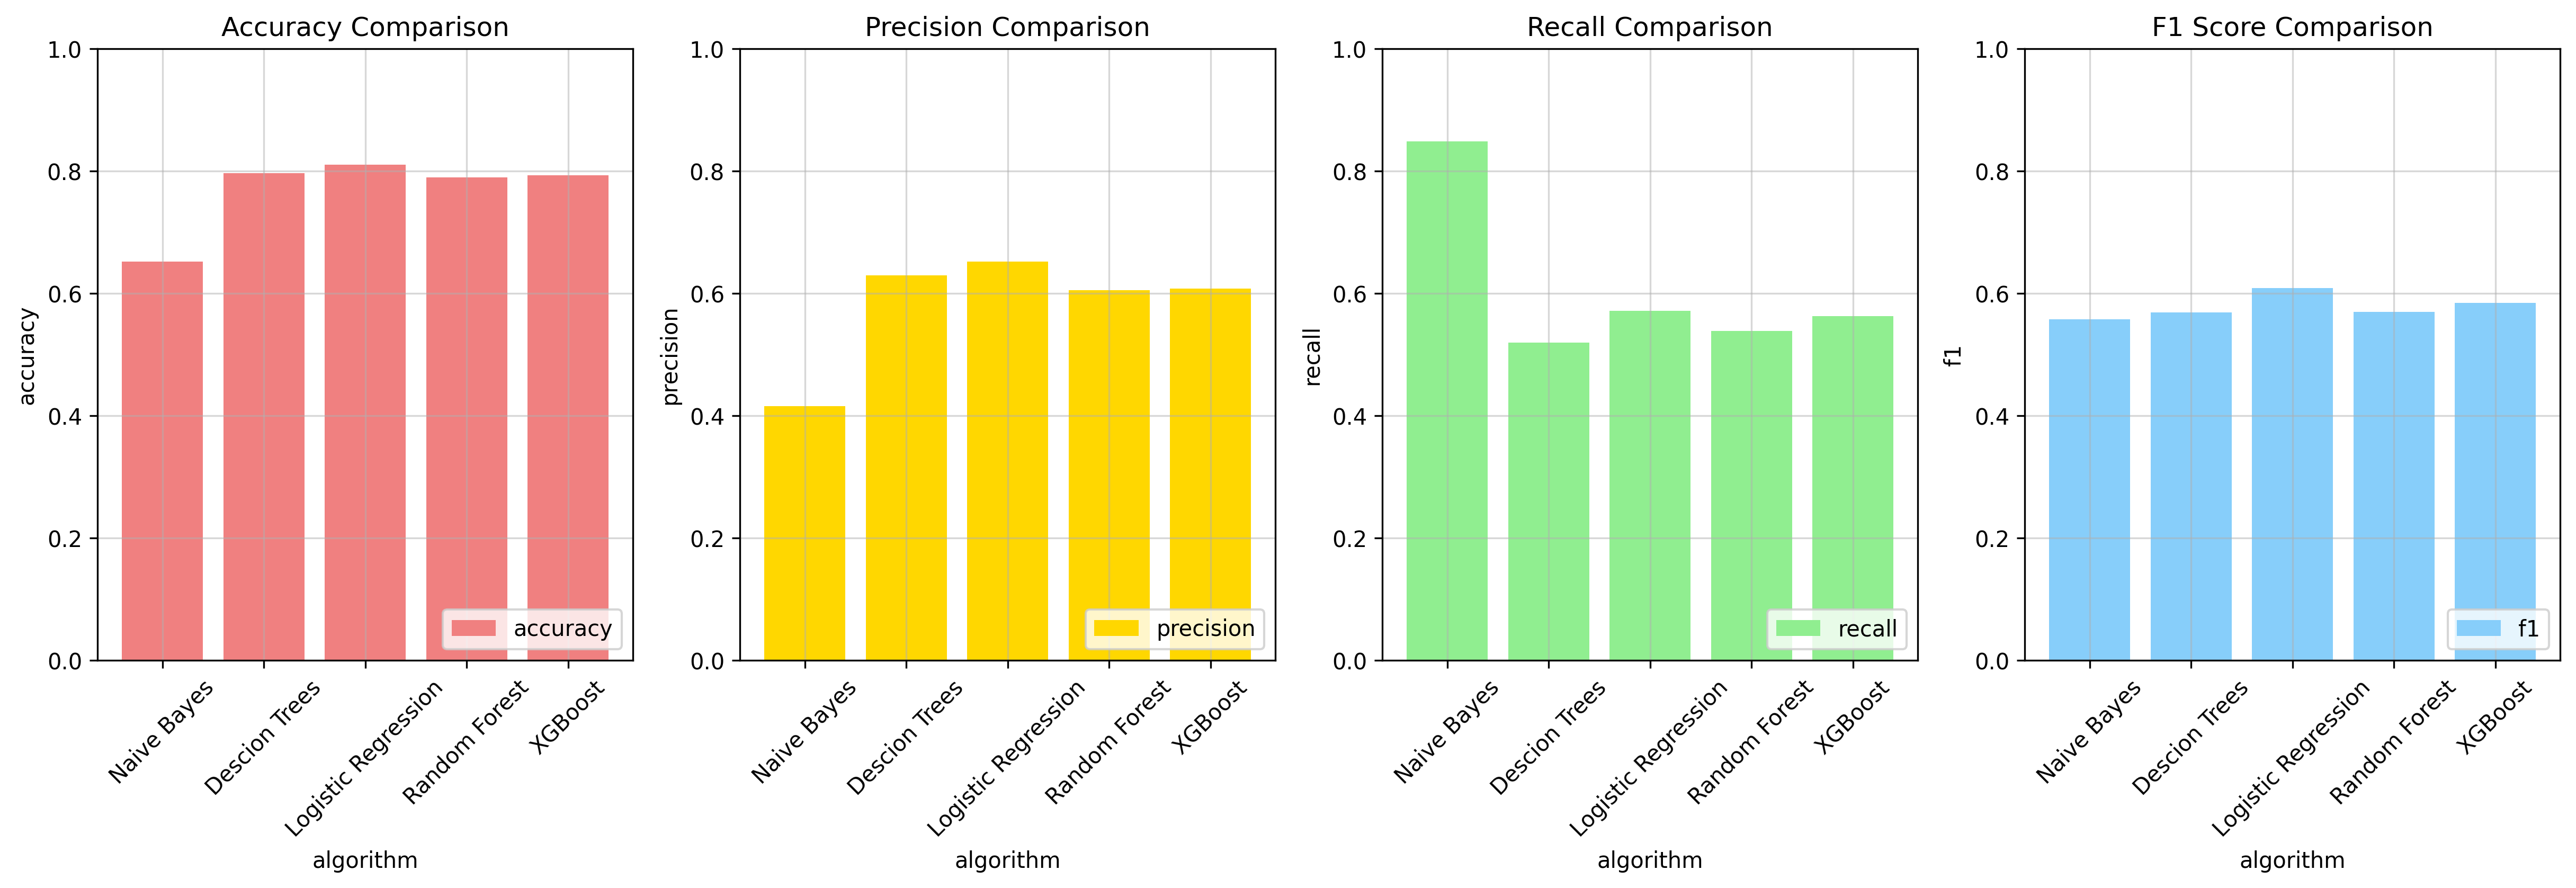

In [28]:
#Comparing all thematrices for this analysis

fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_no_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_no_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_no_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_no_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

Predicting using SMOTE

this is the part where the previous part is repeated but with using SMOTE METHOD.This method deals with imbalances in the dataset in regards to classification labels. Normally, due to the class imbalance, the majority class will have better performance than the minority class. SMOTE deals with this by oversampling the minority class.

In [29]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train, Y_train)

In [31]:
#Naive Bayes with SMOTE

nb_smote = GaussianNB()
nb_smote.fit(X_resampled, y_resampled)
nb_smote_predictions = nb_smote.predict(X_test)

In [32]:
nb_smote_accuracy_score = accuracy_score(Y_test,nb_smote_predictions)
nb_smote_precision_score = precision_score(Y_test,nb_smote_predictions)
nb_smote_recall_score = recall_score(Y_test,nb_smote_predictions)
nb_smote_f1_score = f1_score(Y_test,nb_smote_predictions)
nb_smote_confusion = confusion_matrix(Y_test,nb_smote_predictions)

In [33]:
final_results_smote.loc[len(final_results_smote)] = ["Naive Bayes",nb_smote_accuracy_score,nb_smote_precision_score,nb_smote_recall_score,nb_smote_f1_score]

In [34]:
# Train-test split for resampled data
from sklearn.metrics import classification_report # Importing the classification_report function
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

# Decision Tree Classifier with SMOTEENN
model_dt_smote = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt_smote.fit(xr_train, yr_train)

# Predicting and evaluating Decision Tree model
yr_predict = model_dt_smote.predict(xr_test)
dt_accuracy_score = accuracy_score(yr_test, yr_predict)
model_score_r = model_dt_smote.score(xr_test, yr_test)

print("Decision Tree Accuracy Score:", dt_accuracy_score)
print("Model Score (Accuracy):", model_score_r)
print(classification_report(yr_test, yr_predict)) # Now classification_report is accessible

# Storing final results
final_results_smote.loc[len(final_results_smote)] = ["Decision Tree", dt_accuracy_score, model_score_r, nb_smote_recall_score, nb_smote_f1_score]

Decision Tree Accuracy Score: 0.9161290322580645
Model Score (Accuracy): 0.9161290322580645
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       418
           1       0.92      0.93      0.92       512

    accuracy                           0.92       930
   macro avg       0.92      0.91      0.92       930
weighted avg       0.92      0.92      0.92       930



In [35]:
final_results_smote.loc[len(final_results_smote)] = ["Decison Tree",dt_accuracy_score,model_score_r,nb_smote_recall_score,nb_smote_f1_score]

In [36]:
from sklearn import metrics

# Train the model
model_dt_smote.fit(xr_train, yr_train)

# Make predictions
yr_predict = model_dt_smote.predict(xr_test)

# Get the accuracy score
model_score_r = model_dt_smote.score(xr_test, yr_test)  # This returns the accuracy

# Print the accuracy
print("Accuracy:", model_score_r)

# Print the classification report
print(metrics.classification_report(yr_test, yr_predict))

Accuracy: 0.9161290322580645
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       418
           1       0.92      0.93      0.92       512

    accuracy                           0.92       930
   macro avg       0.92      0.91      0.92       930
weighted avg       0.92      0.92      0.92       930



In [37]:
#Logistic Regression with SMOTE

lr_smote = LogisticRegression(random_state=0)
lr_smote.fit(X_resampled, y_resampled)
lr_smote_predictions = lr_smote.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
lr_smote_accuracy_score = accuracy_score(Y_test,lr_smote_predictions)
lr_smote_precision_score = precision_score(Y_test,lr_smote_predictions)
lr_smote_recall_score = recall_score(Y_test,lr_smote_predictions)
lr_smote_f1_score = f1_score(Y_test,lr_smote_predictions)
lr_smote_confusion = confusion_matrix(Y_test,lr_smote_predictions)

In [39]:
final_results_smote.loc[len(final_results_smote)] = ["Logistic Regression",lr_smote_accuracy_score,lr_smote_precision_score,lr_smote_recall_score,lr_smote_f1_score]

In [40]:
#Ransdom Forest with SMOTE

rf_smote = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_smote.fit(X_resampled, y_resampled)
rf_smote_predictions = rf_smote.predict(X_test)
rf_smote_predictions = [int(x) for x in np.round(rf_smote_predictions,0)]

In [41]:
rf_smote_accuracy_score = accuracy_score(Y_test,rf_smote_predictions)
rf_smote_precision_score = precision_score(Y_test,rf_smote_predictions)
rf_smote_recall_score = recall_score(Y_test,rf_smote_predictions)
rf_smote_f1_score = f1_score(Y_test,rf_smote_predictions)
rf_smote_confusion = confusion_matrix(Y_test,rf_smote_predictions)

In [42]:
final_results_smote.loc[len(final_results_smote)] = ["Random Forest",rf_smote_accuracy_score,rf_smote_precision_score,rf_smote_recall_score,rf_smote_f1_score]

In [43]:
#XBG Boost with SMOTE

xgb_smote = xgb.XGBClassifier()
xgb_smote.fit(X_resampled, y_resampled)
xgb_smote_predictions = xgb_smote.predict(X_test)

In [44]:
xgb_smote_accuracy_score = accuracy_score(Y_test,xgb_smote_predictions)
xgb_smote_precision_score = precision_score(Y_test,xgb_smote_predictions)
xgb_smote_recall_score = recall_score(Y_test,xgb_smote_predictions)
xgb_smote_f1_score = f1_score(Y_test,xgb_smote_predictions)
xgb_smote_confusion = confusion_matrix(Y_test,xgb_smote_predictions)

In [45]:
final_results_smote.loc[len(final_results_smote)] = ["XGBoost",xgb_smote_accuracy_score,xgb_smote_precision_score,xgb_smote_recall_score,xgb_smote_f1_score]

In [46]:
#comparing result for this stage

final_results_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.710433,0.466049,0.829670,0.596838
1,Decision Tree,0.916129,0.916129,0.829670,0.596838
2,Decison Tree,0.916129,0.916129,0.829670,0.596838
3,Logistic Regression,0.730305,0.486159,0.771978,0.596603
4,Random Forest,0.761533,0.527451,0.739011,0.615561
5,XGBoost,0.762243,0.529652,0.711538,0.607268


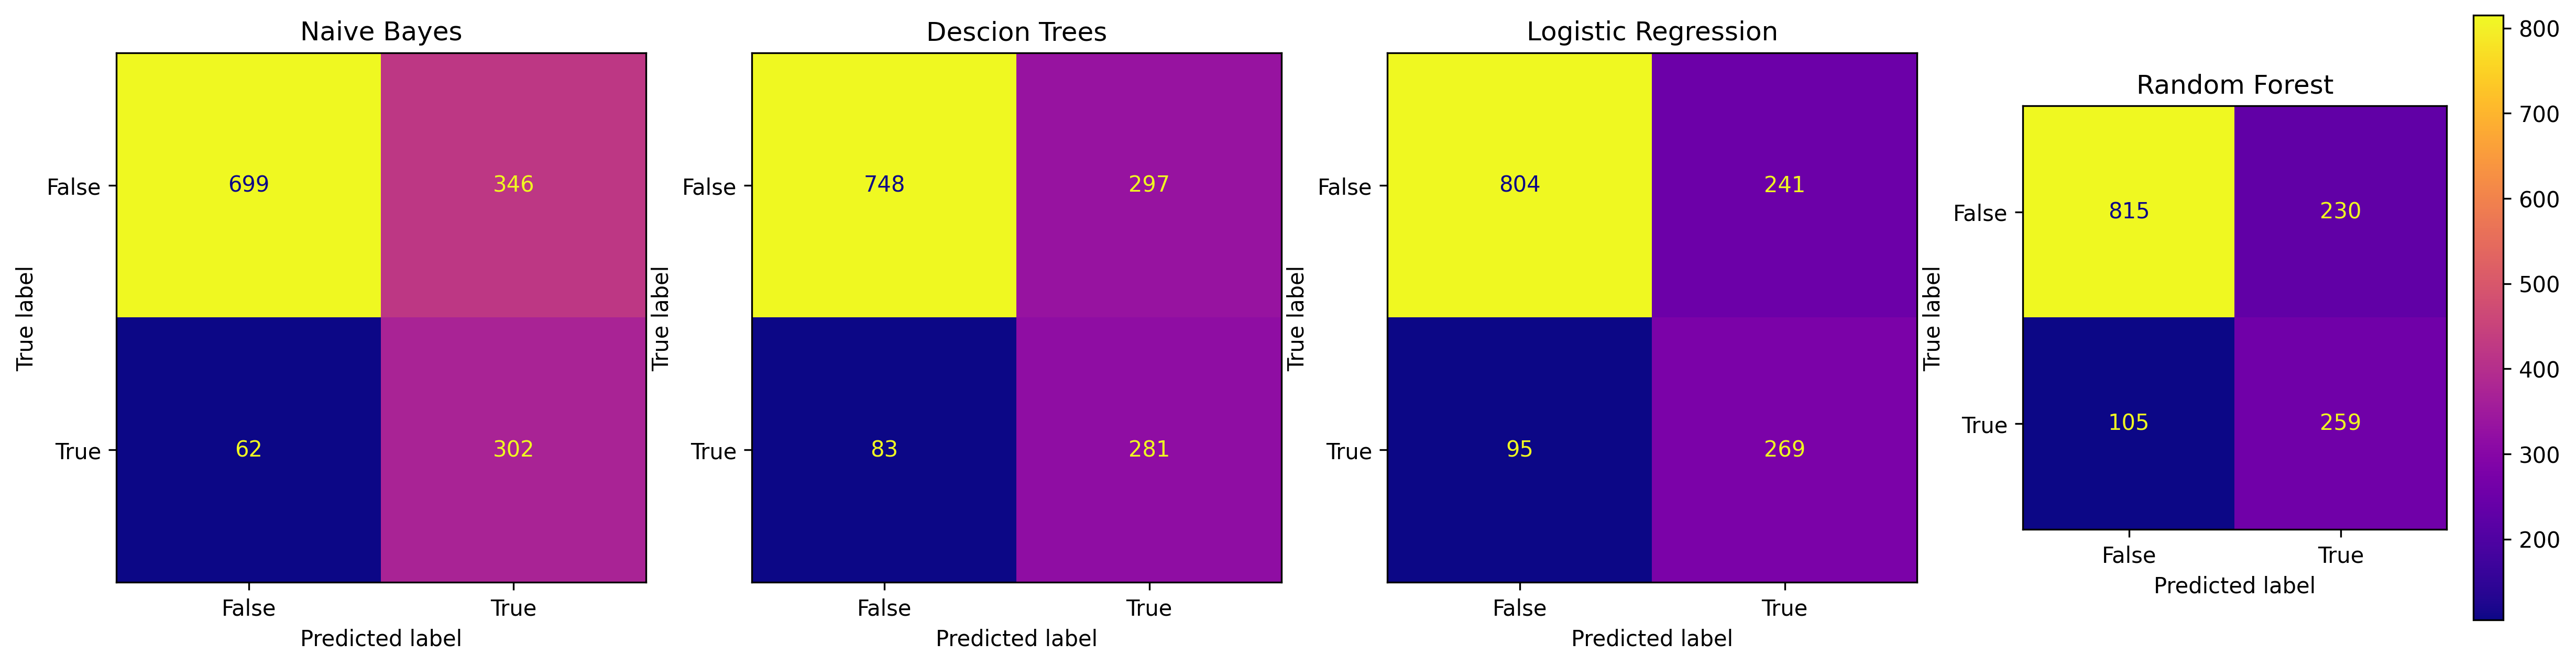

In [47]:
#comparing confusion matrices
fig, ax = plt.subplots(1,4,sharex=False, sharey=False, figsize=(20, 5), dpi=300)
ax[0].set_title(x_labels[0])
ax[1].set_title(x_labels[1])
ax[2].set_title(x_labels[2])
ax[3].set_title(x_labels[3])

ConfusionMatrixDisplay(nb_smote_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(lr_smote_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_smote_confusion,display_labels=[False,True]).plot(ax=ax[2],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_smote_confusion,display_labels=[False,True]).plot(ax=ax[3],cmap='plasma',colorbar=True)
fig.show()

In [ ]:
#Naive Bayes has the most varied confusion matrix, but has the least number of True Negatives.
# The other three models have similar proportions to each other in terms of Negatives and Postives.

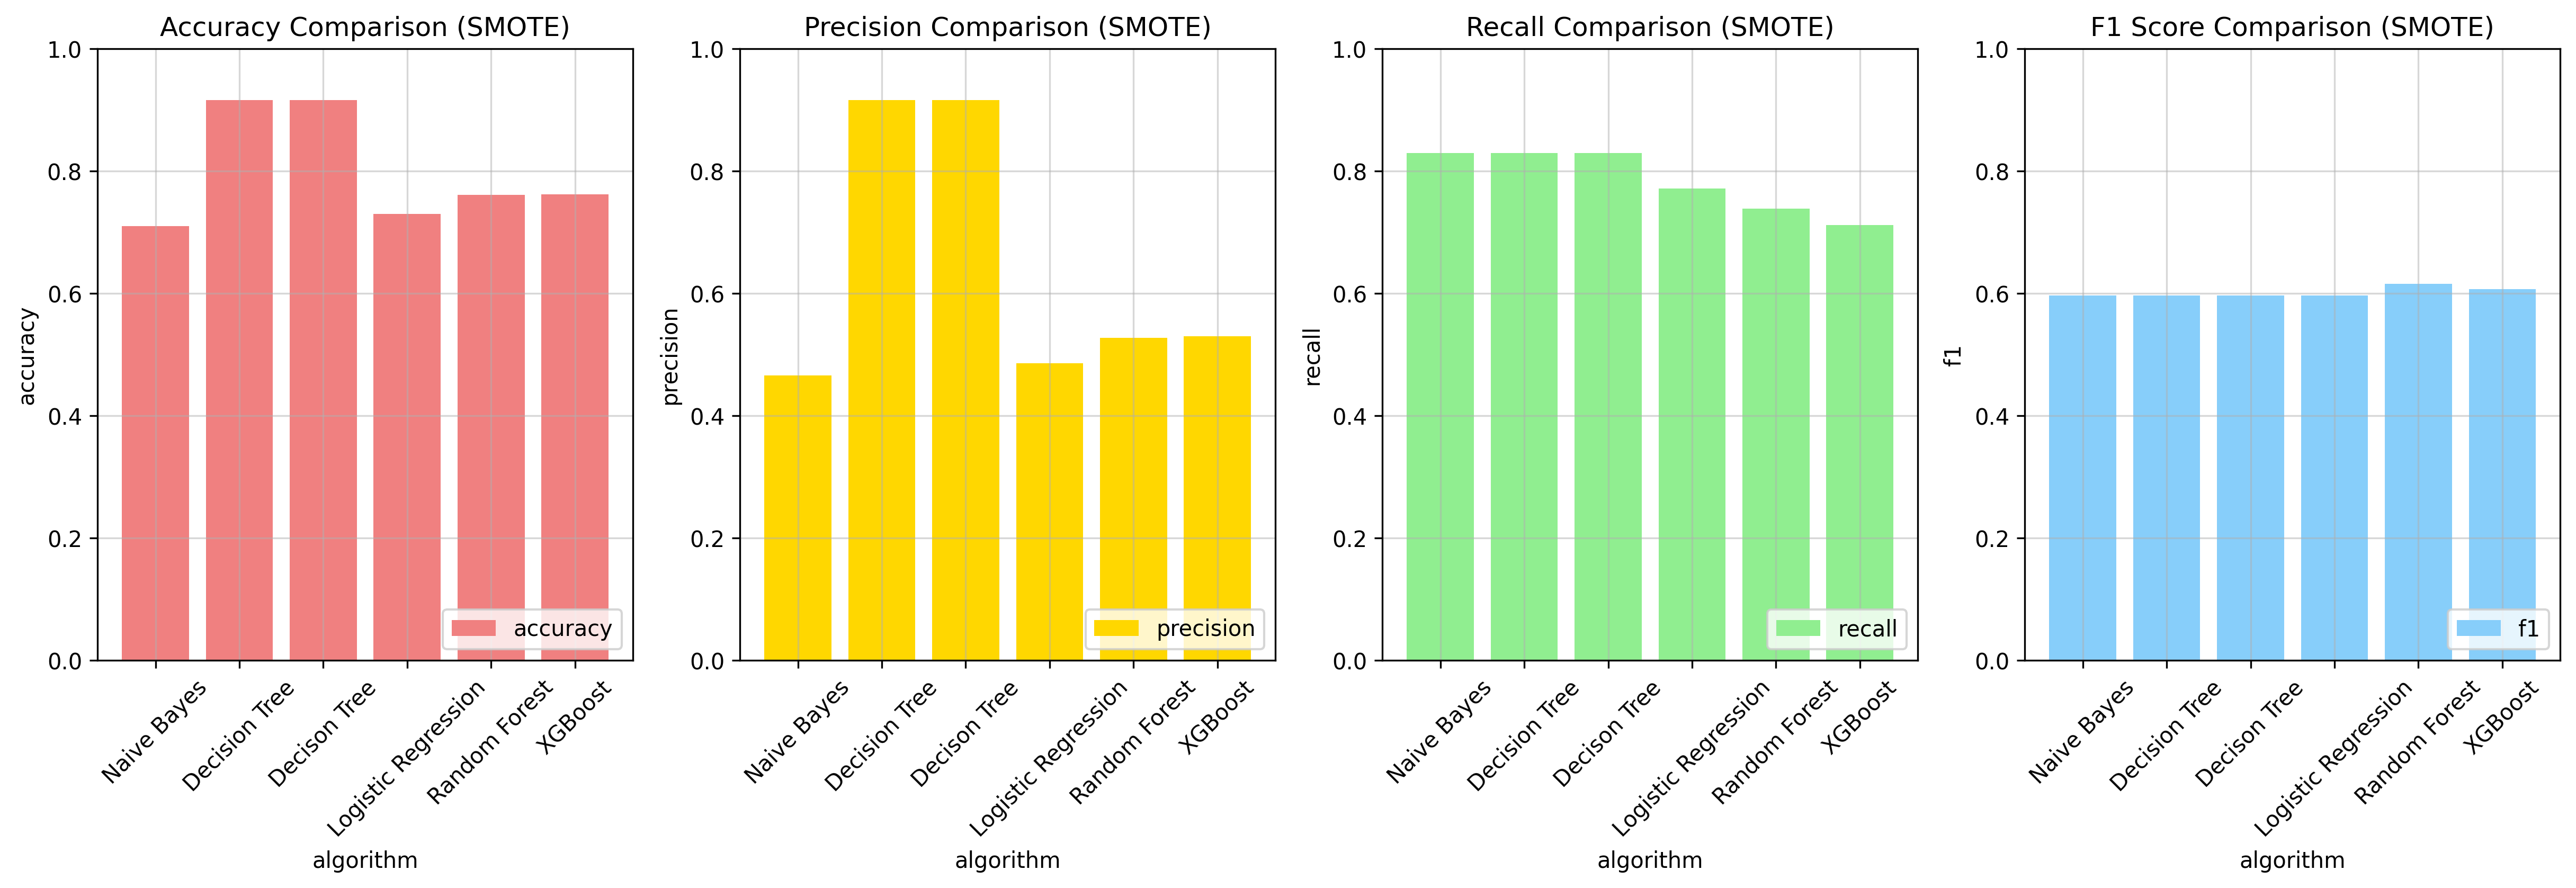

In [48]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison (SMOTE)")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison (SMOTE)")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison (SMOTE)")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison (SMOTE)")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

Predictions using Hyperparameter Tuning (only for Random Forests and XGBoost)

In [49]:
#Random Forests - Hyperparameter Tuning

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [50]:
# estimating the parameters
est_rf_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [51]:
# using estimated parameter grid and doing RandomizedSearchCV before fitting
est_rf_hyp_model = RandomForestRegressor(random_state = 42)
est_rf_hyp = RandomizedSearchCV(est_rf_hyp_model,est_rf_params,n_iter=10,cv=3,n_jobs=-1)
est_rf_hyp.fit(X_train, Y_train)
est_rf_hyp_predictions = est_rf_hyp.predict(X_test)
est_rf_hyp_predictions = [int(x) for x in np.round(est_rf_hyp_predictions,0)];

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

In [53]:
est_rf_hyp_accuracy_score = accuracy_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_precision_score = precision_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_accuracy_score = accuracy_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_precision_score = precision_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_recall_score = recall_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_f1_score = f1_score(Y_test,est_rf_hyp_predictions)
final_results_hyp[len(final_results_hyp)] = ["Random Forest - RandomizedSearchCV",est_rf_hyp_accuracy_score,est_rf_hyp_precision_score,est_rf_hyp_recall_score,est_rf_hyp_f1_score]


In [54]:
# getting obtained best paramters from RandomizedSearchCV
rf_hyp_params = est_rf_hyp.best_params_
print(rf_hyp_params)

{'n_estimators': 780, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}


In [55]:
# converting these parameters to be read
rf_hyp_param_values = {}
for key, value in rf_hyp_params.items():
    rf_hyp_param_values[key] = [value]
print(rf_hyp_param_values)

{'n_estimators': [780], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [9], 'bootstrap': [True]}


In [56]:
# using obtained best parameters and doing GridSearchCV before fitting
rf_hyp_model = RandomForestRegressor(random_state = 42)
rf_hyp = GridSearchCV(rf_hyp_model,rf_hyp_param_values,cv=3,n_jobs=-1)
rf_hyp.fit(X_train, Y_train)
rf_hyp_predictions = rf_hyp.predict(X_test)
rf_hyp_predictions = [int(x) for x in np.round(rf_hyp_predictions,0)]

In [61]:
rf_hyp_accuracy_score = accuracy_score(Y_test,rf_hyp_predictions)
rf_hyp_precision_score = precision_score(Y_test,rf_hyp_predictions)
rf_hyp_recall_score = recall_score(Y_test,rf_hyp_predictions)
rf_hyp_f1_score = f1_score(Y_test,rf_hyp_predictions)
rf_hyp_confusion = confusion_matrix(Y_test,rf_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["Random Forest - GridSearchCV", rf_hyp_accuracy_score, rf_hyp_precision_score, rf_hyp_recall_score, rf_hyp_f1_score, np.nan]

In [62]:
#XGBoost - Hyperparameter Tuning

# estimating the parameters

est_xgb_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [63]:
# using estimated parameter grid and doing RandomizedSearchCV before fitting
est_xgb_hyp_model = RandomForestRegressor(random_state = 42)
est_xgb_hyp = RandomizedSearchCV(est_xgb_hyp_model,est_xgb_params,n_iter=10,cv=3,n_jobs=-1)
est_xgb_hyp.fit(X_train, Y_train)
est_xgb_hyp_predictions = est_xgb_hyp.predict(X_test)
est_xgb_hyp_predictions = [int(x) for x in np.round(est_xgb_hyp_predictions,0)];

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

In [66]:
est_xgb_hyp_accuracy_score = accuracy_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_precision_score = precision_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_recall_score = recall_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_f1_score = f1_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_confusion = confusion_matrix(Y_test,est_xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - RandomizedSearchCV",est_xgb_hyp_accuracy_score,est_xgb_hyp_precision_score,est_xgb_hyp_recall_score,est_xgb_hyp_f1_score, np.nan]

In [67]:
# getting obtained best paramters from RandomizedSearchCV
xgb_hyp_params = est_xgb_hyp.best_params_
print(xgb_hyp_params)

{'n_estimators': 740, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [68]:
# converting these parameters to be read
xgb_hyp_param_values = {}
for key, value in xgb_hyp_params.items():
    xgb_hyp_param_values[key] = [value]
print(xgb_hyp_param_values)

{'n_estimators': [740], 'min_samples_split': [10], 'min_samples_leaf': [4], 'max_features': ['sqrt'], 'max_depth': [8], 'bootstrap': [True]}


In [69]:
# using obtained best parameters and doing GridSearchCV before fitting
xgb_hyp_model = RandomForestRegressor(random_state = 42)
xgb_hyp = GridSearchCV(xgb_hyp_model,xgb_hyp_param_values,cv=3,n_jobs=-1)
xgb_hyp.fit(X_train, Y_train)
xgb_hyp_predictions = xgb_hyp.predict(X_test)
xgb_hyp_predictions = [int(x) for x in np.round(xgb_hyp_predictions,0)];

In [71]:
xgb_hyp_accuracy_score = accuracy_score(Y_test,xgb_hyp_predictions)
xgb_hyp_precision_score = precision_score(Y_test,xgb_hyp_predictions)
xgb_hyp_recall_score = recall_score(Y_test,xgb_hyp_predictions)
xgb_hyp_f1_score = f1_score(Y_test,xgb_hyp_predictions)
xgb_hyp_confusion = confusion_matrix(Y_test,xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - GridSearchCV",xgb_hyp_accuracy_score,xgb_hyp_precision_score,xgb_hyp_recall_score,xgb_hyp_f1_score, np.nan]

Comparing Results (Hyperparameter Tuning)

In [72]:
# examining data table for this stage of analysis
final_results_hyp

,method,accuracy,precision,recall,f1,0
0,NaN,NaN,NaN,NaN,NaN,Random Forest - RandomizedSearchCV
1,NaN,NaN,NaN,NaN,NaN,0.797729
2,NaN,NaN,NaN,NaN,NaN,0.626198
3,NaN,NaN,NaN,NaN,NaN,0.538462
4,NaN,NaN,NaN,NaN,NaN,0.579025
5,Random Forest - GridSearchCV,0.797729,0.626198,0.538462,0.579025,NaN
6,XGBoost - RandomizedSearchCV,0.797729,0.629508,0.527473,0.573991,NaN
7,XGBoost - RandomizedSearchCV,0.797729,0.629508,0.527473,0.573991,NaN
8,XGBoost - GridSearchCV,0.797729,0.629508,0.527473,0.573991,NaN


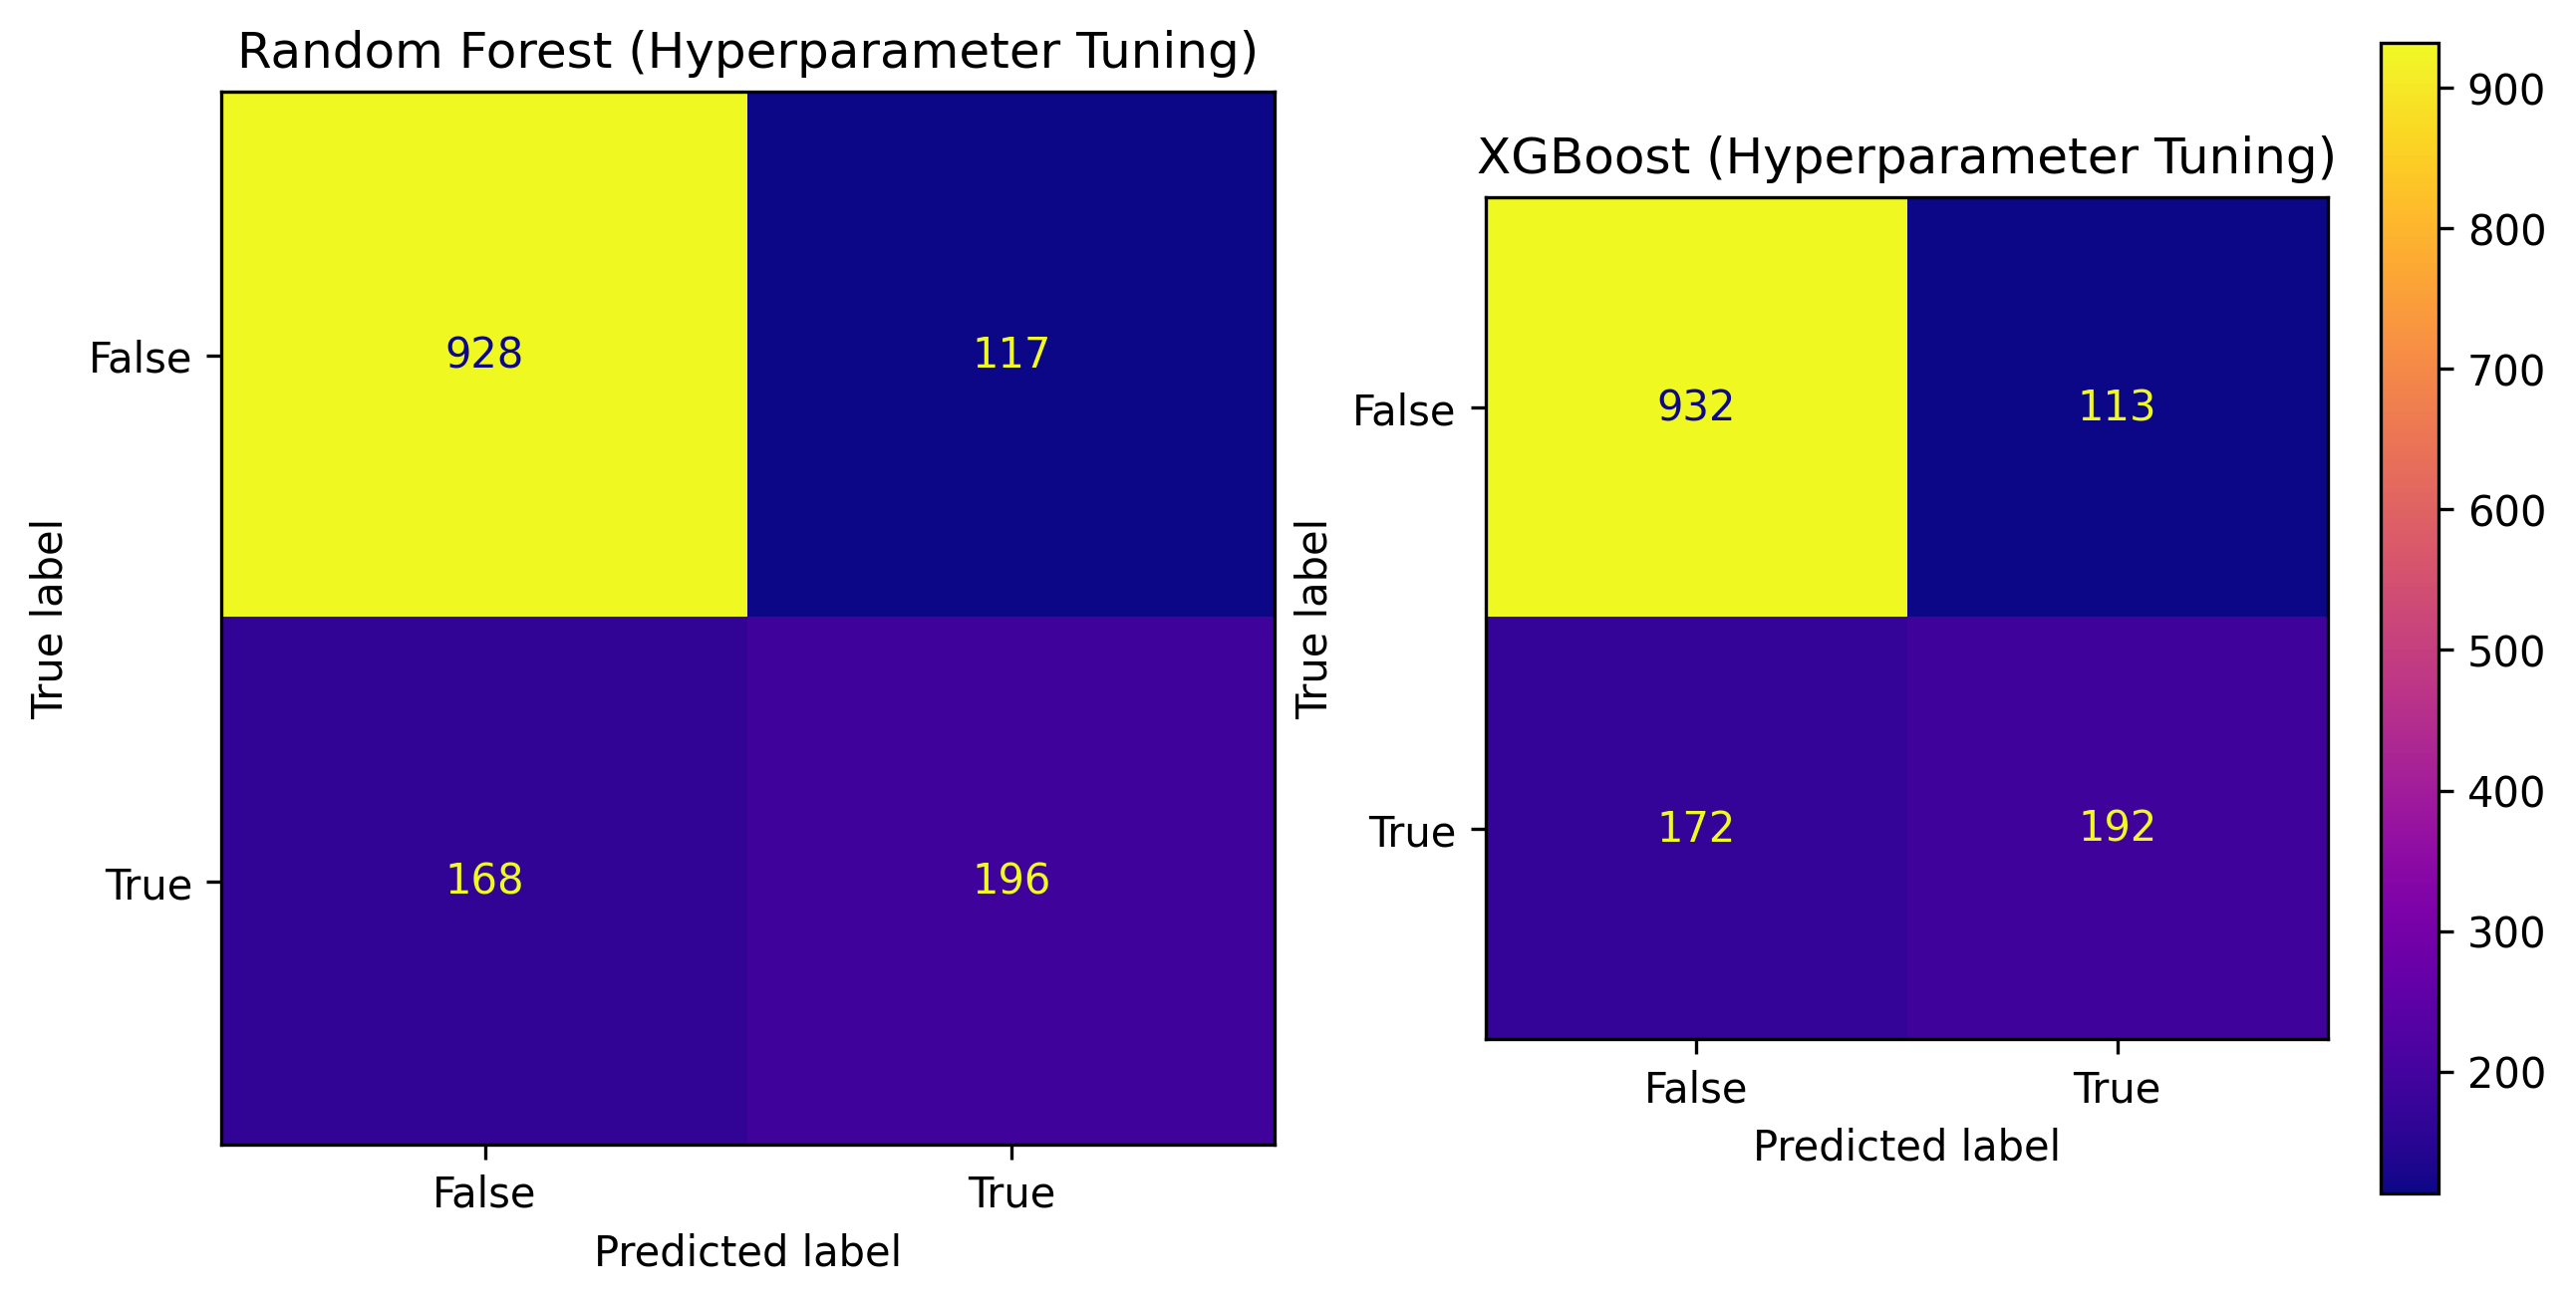

In [73]:
# comparing confusion matrices for this stage of analysis
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(10, 5), dpi=300)
ax[0].set_title('Random Forest (Hyperparameter Tuning)')
ax[1].set_title('XGBoost (Hyperparameter Tuning)')

ConfusionMatrixDisplay(rf_hyp_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_hyp_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=True)
fig.show()

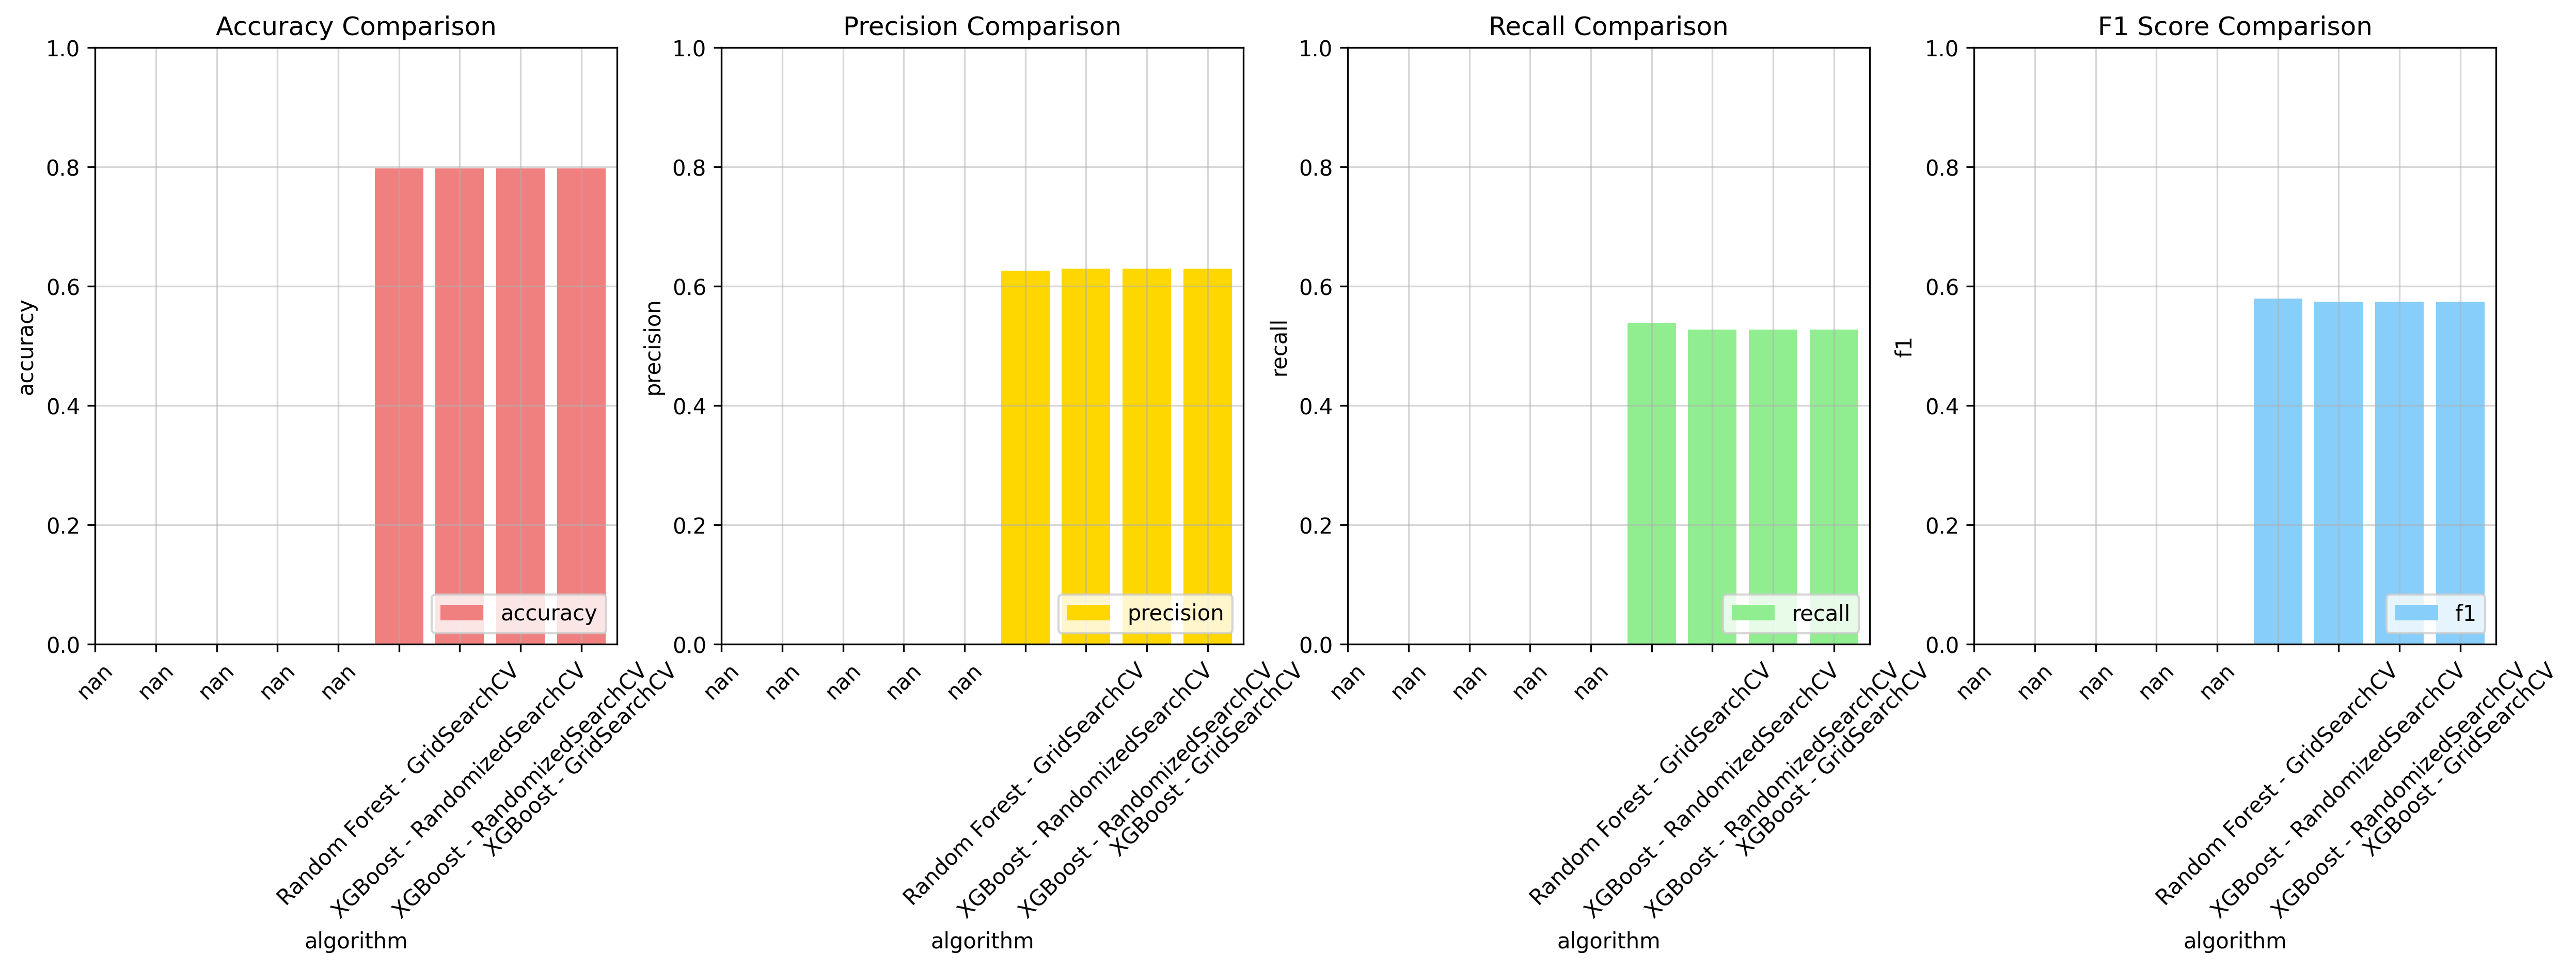

In [74]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_hyp['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_hyp['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_hyp['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_hyp['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_hyp['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

In [ ]:
# comparing the results of hyperparameter tuning with the first two stages of analysis - non-SMOTE and SMOTE.

In [75]:
# preparing dataframes for comparing all three stages of analysis
pre_hyp_comparison_no_smote = final_results_no_smote[2:4]
pre_hyp_comparison_smote = final_results_smote[2:4]
post_hyp_comparison = final_results_hyp.iloc[[0,2]]

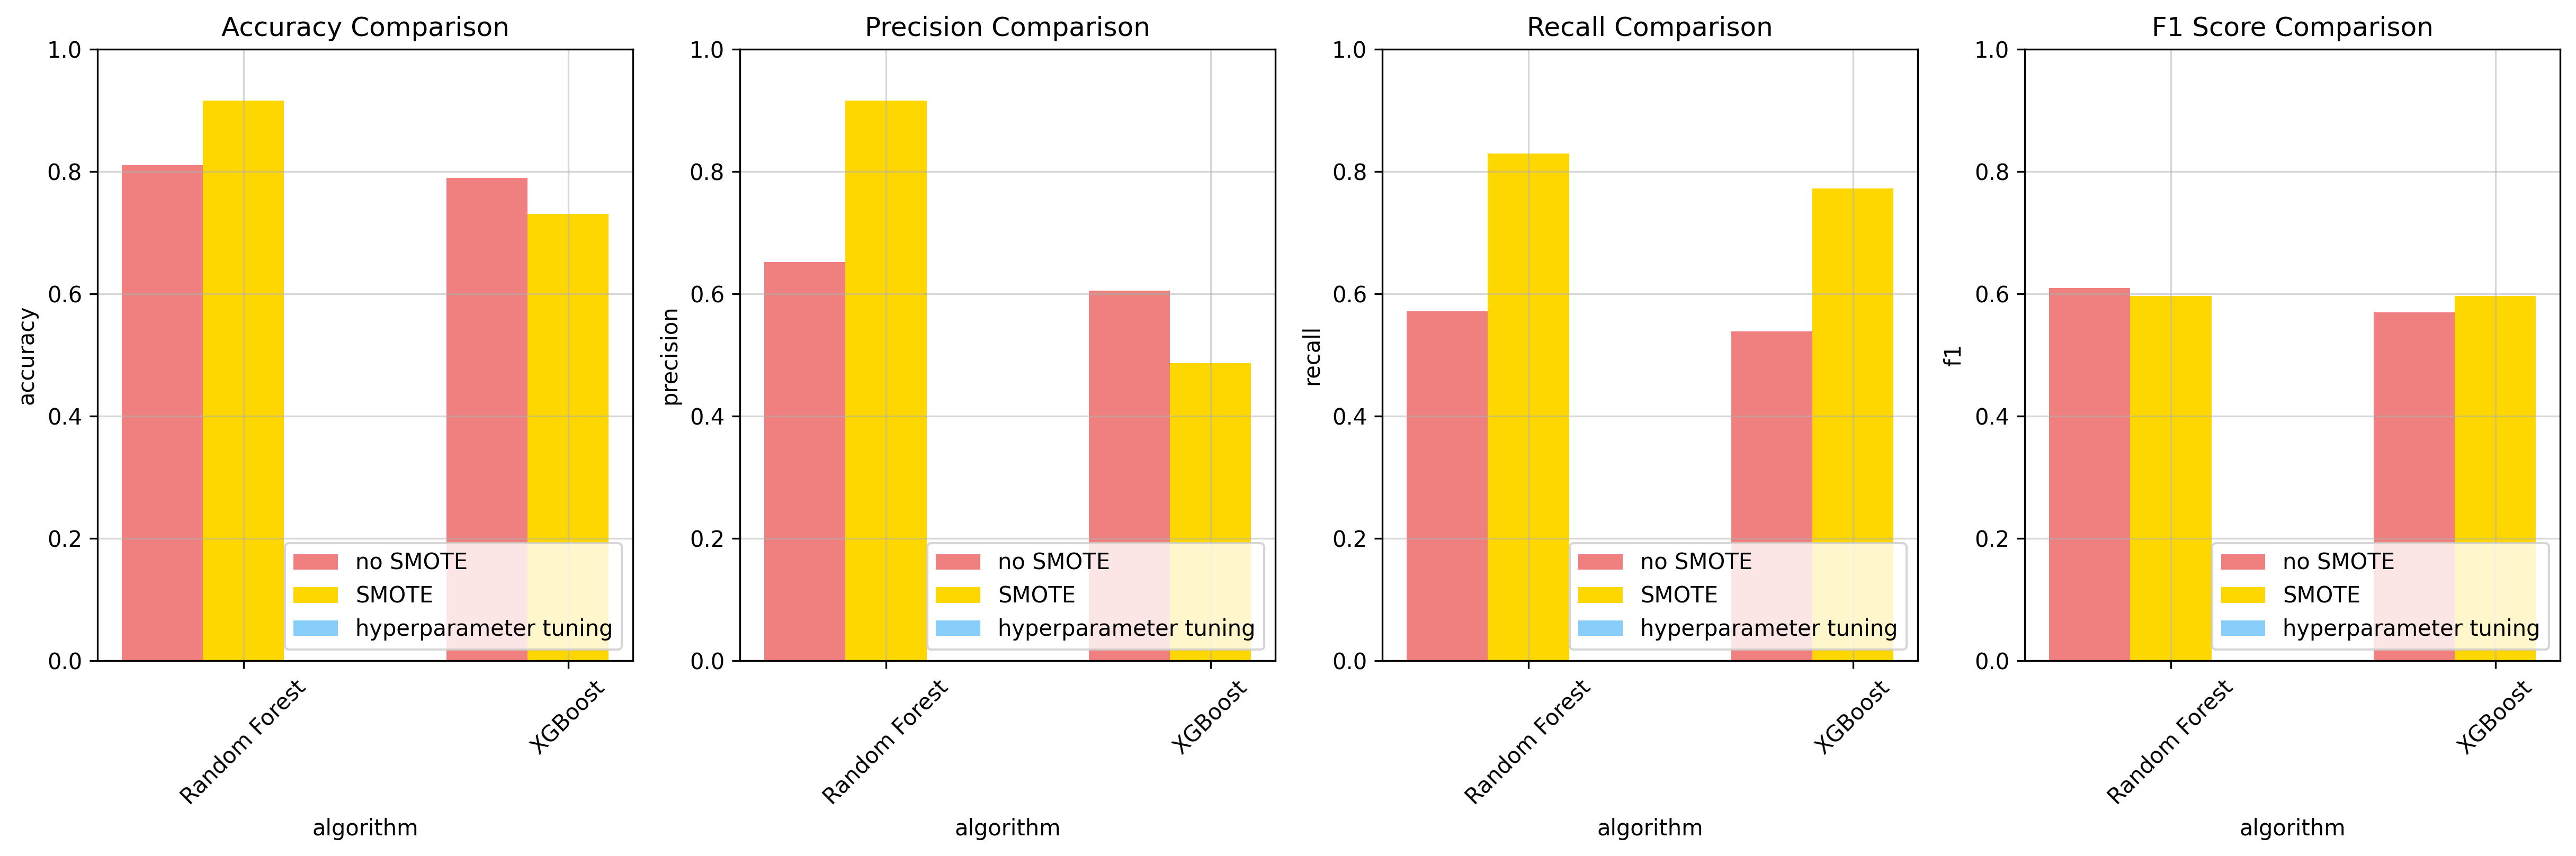

In [84]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = ['Random Forest','XGBoost']
indices = np.arange(len(x_labels))
width = 0.25

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices+width,pre_hyp_comparison_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[0].bar(indices+2*width,pre_hyp_comparison_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[0].bar(indices+3*width,post_hyp_comparison['accuracy'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices+width,pre_hyp_comparison_no_smote['precision'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[1].bar(indices+2*width,pre_hyp_comparison_smote['precision'],width,color="gold",alpha=1,label="SMOTE")
ax[1].bar(indices+3*width,post_hyp_comparison['precision'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices+width,pre_hyp_comparison_no_smote['recall'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[2].bar(indices+2*width,pre_hyp_comparison_smote['recall'],width,color="gold",alpha=1,label="SMOTE")
ax[2].bar(indices+3*width,post_hyp_comparison['recall'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices+width,pre_hyp_comparison_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[3].bar(indices+2*width,pre_hyp_comparison_smote['f1'],width,color="gold",alpha=1,label="SMOTE")
ax[3].bar(indices+3*width,post_hyp_comparison['f1'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices+2*width, x_labels, rotation=45)

Comparison of all Stages of Analysis

In [79]:
import pandas as pd

# Replace values in `final_results_smote`
tmp_final_results_smote = final_results_smote.replace({
    'Naive Bayes': 'Naive Bayes (SMOTE)',
    'Logistic Regression': 'Logistic Regression (SMOTE)',
    'Random Forest': 'Random Forest (SMOTE)',
    'XGBoost': 'XGBoost (SMOTE)'
})

# Use `pd.concat()` instead of `append()` to combine DataFrames
all_results_combined = pd.concat([final_results_no_smote, tmp_final_results_smote, final_results_hyp])

# Sort and reset the index
final_results = all_results_combined.sort_values('recall', ascending=False).reset_index(drop=True)


In [80]:
final_results

,method,accuracy,precision,recall,f1,0
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762,NaN
1,Naive Bayes (SMOTE),0.710433,0.466049,0.829670,0.596838,NaN
2,Decision Tree,0.916129,0.916129,0.829670,0.596838,NaN
3,Decison Tree,0.916129,0.916129,0.829670,0.596838,NaN
4,Logistic Regression (SMOTE),0.730305,0.486159,0.771978,0.596603,NaN
5,Random Forest (SMOTE),0.761533,0.527451,0.739011,0.615561,NaN
6,XGBoost (SMOTE),0.762243,0.529652,0.711538,0.607268,NaN
7,Logistic Regression,0.810504,0.652038,0.571429,0.609078,NaN
8,XGBoost,0.793471,0.608309,0.563187,0.584879,NaN
9,Random Forest,0.789922,0.604938,0.538462,0.569767,NaN


## Conclusion:

To conclude this project,  these aare the rankings the best results for each stage of analysis, and then rank the best results overall for this dataset in terms of predicting churn values. Data is splitted into an 80% training set and 20% testing set. I have used the recall metric as the defining metric, due to it being proportionate with the number of True Negatives in terms of predictions. models with higher recall values are the best for predicting churned customers because there are significantly less True Negatives in the predictions.

--> Stage One of Analysis: Normal Predictions

1.Naive Bayes
2.XGBoost
3.Logistic Regression
4.Random Forest

--> Stage Two of Analysis: Predictions using SMOTE

1.Naive Bayes
2.Logistic Regression
3.Random Forest
4.XGBoost

-->Stage Three of Analysis - Predictions using Hyperparameter Tuning (only for Random Forests and XGBoost)

1.Random Forest
2.XGBoost

-->Overall (all stages of analysis):

Naive Bayes